In [1]:
from find_source import summary

{'field_center': (0, 0),
 'rms_val': 0.0007672836654819548,
 'mad': 0.000521551410201937,
 'sd_mad': 0.0007689678178559412,
 'n_incl_meas': 20.420300911272722,
 'n_excl_meas': 601.9524528146684,
 'fwhm': 3.26538144,
 'incl_radius': 8.26538144,
 'int_peak_val': [0.04773866463622206],
 'int_peak_coord': [(1.2452249923428522, -5.615753602336201)],
 'int_prob': [0.0],
 'int_snr': [62.2177517701174],
 'ext_peak_val': [0.006583510898053646],
 'ext_peak_coord': [(-0.6693053702765946, -18.09166941389514)],
 'ext_prob': [6.217169705782555e-13],
 'ext_snr': [8.300079548890277],
 'calc_rms_val': 0.0009917820759848288,
 'calc_ext_prob': 1.0000000000000004,
 'calc_ext_snr': 2.9362073488138667,
 'calc_int_prob': [0.0],
 'calc_int_snr': [48.13422806498907]}

<Figure size 384x288 with 0 Axes>

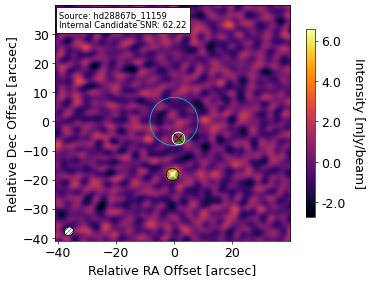

In [2]:
summary('../data/multi_track/hd28867b_11159.fits')

{'field_center': (0, 0),
 'rms_val': 0.0008235647110268474,
 'mad': 0.0005518586840480566,
 'sd_mad': 0.0008136524218637984,
 'n_incl_meas': 19.813071504083663,
 'n_excl_meas': 551.803299833358,
 'fwhm': 3.4466479199999998,
 'incl_radius': 8.44664792,
 'int_peak_val': [0.000960996880724513,
  0.01504664297089937,
  0.05149473020267176,
  0.0480059022906312],
 'int_peak_coord': [(0.9641838208345648, -5.450749050032135),
  (0.6459553433738531, 2.1074830863064493),
  (-2.3667043082323738, 7.6115797680394515),
  (3.988761450640146, -2.066845374584488)],
 'int_prob': [2.4072034975778998, 1.4050878834436412e-56, 0.0, 0.0],
 'int_snr': [1.1668747675289666,
  18.27014048736829,
  62.52663514256997,
  58.29038282951181],
 'ext_peak_val': [0.010683788917958736],
 'ext_peak_coord': [(-0.629942403993764, -18.20555360897409)],
 'ext_prob': [3.795236437105149e-26],
 'ext_snr': [12.083665643949638],
 'calc_rms_val': 0.0010627592254885698,
 'calc_ext_prob': 1.0000000000000004,
 'calc_ext_snr': 2.90911

<Figure size 384x288 with 0 Axes>

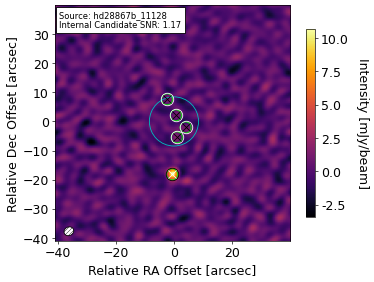

In [3]:
summary('../data/multi_track/hd28867b_11128.fits')